## 1. Load datasets, Libraries, and prepare for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
import umap

c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_test = pd.read_parquet('test.parquet', engine='pyarrow')

In [48]:
list(df_train.columns.values)

['id',
 'channel_1',
 'channel_10',
 'channel_11',
 'channel_12',
 'channel_13',
 'channel_14',
 'channel_15',
 'channel_16',
 'channel_17',
 'channel_18',
 'channel_19',
 'channel_2',
 'channel_20',
 'channel_21',
 'channel_22',
 'channel_23',
 'channel_24',
 'channel_25',
 'channel_26',
 'channel_27',
 'channel_28',
 'channel_29',
 'channel_3',
 'channel_30',
 'channel_31',
 'channel_32',
 'channel_33',
 'channel_34',
 'channel_35',
 'channel_36',
 'channel_37',
 'channel_38',
 'channel_39',
 'channel_4',
 'channel_40',
 'channel_41',
 'channel_42',
 'channel_43',
 'channel_44',
 'channel_45',
 'channel_46',
 'channel_47',
 'channel_48',
 'channel_49',
 'channel_5',
 'channel_50',
 'channel_51',
 'channel_52',
 'channel_53',
 'channel_54',
 'channel_55',
 'channel_56',
 'channel_57',
 'channel_58',
 'channel_59',
 'channel_6',
 'channel_60',
 'channel_61',
 'channel_62',
 'channel_63',
 'channel_64',
 'channel_65',
 'channel_66',
 'channel_67',
 'channel_68',
 'channel_69',
 'channel

In [4]:
# df_train.describe()

In [5]:
# From the original dataset description, The subset of 6 channels 41-46 is recommended as a
# good starting point for developing and testing algorithms before applying them to the full set.

df_train_4146 = df_train[['id', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'is_anomaly']].copy()
df_train_4146

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
0,0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
1,1,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
2,2,0.821213,0.789557,0.770317,0.809411,0.816006,0.765296,0
3,3,0.819642,0.786344,0.770317,0.807050,0.816855,0.766985,0
4,4,0.821996,0.788753,0.770317,0.807837,0.818551,0.761073,0
...,...,...,...,...,...,...,...,...
14728316,14728316,0.806299,0.799999,0.767944,0.792093,0.821094,0.752628,0
14728317,14728317,0.806299,0.790360,0.765569,0.792881,0.821941,0.763607,0
14728318,14728318,0.806299,0.795180,0.765569,0.792881,0.822790,0.762762,0
14728319,14728319,0.806299,0.796786,0.767152,0.796816,0.820247,0.761073,0


In [6]:
num_anomaly = df_train_4146['is_anomaly'].value_counts().get(1, 0)
num_nominal = df_train_4146['is_anomaly'].value_counts().get(0, 0)

print('# of anomalies: ' + str(num_anomaly))
print('# of nominal: ' + str(num_nominal))

print('proportion of anomalies: ' + str((round(num_anomaly/len(df_train_4146), 4)*100)) + '%')

# of anomalies: 1544104
# of nominal: 13184217
proportion of anomalies: 10.48%


In [7]:
# To make our analysis faster in the beginning, we will get a sample of 100.000 rows
# later, we can apply the analysis in the whole dataset to check

df_sample = df_train_4146.sample(n=100000, random_state=42).sort_values(by=["id"])
df_sample

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
230,230,0.814149,0.779114,0.781396,0.800752,0.808375,0.781340,0
565,565,0.808654,0.794377,0.774274,0.794455,0.824486,0.762762,0
578,578,0.814149,0.796786,0.770317,0.803901,0.825333,0.761918,0
586,586,0.817288,0.789557,0.770317,0.804688,0.820247,0.762762,0
842,842,0.808654,0.792770,0.781396,0.795242,0.816006,0.776273,0
...,...,...,...,...,...,...,...,...
14727246,14727246,0.809439,0.783130,0.763195,0.797604,0.816855,0.749250,0
14727614,14727614,0.803945,0.787950,0.772691,0.792881,0.816006,0.766985,0
14727642,14727642,0.811793,0.787147,0.763195,0.802327,0.817702,0.756850,0
14727989,14727989,0.808654,0.776705,0.777439,0.797604,0.808375,0.782185,0


## 2. Visualize data

### 2.1. Visualize all channels in different charts

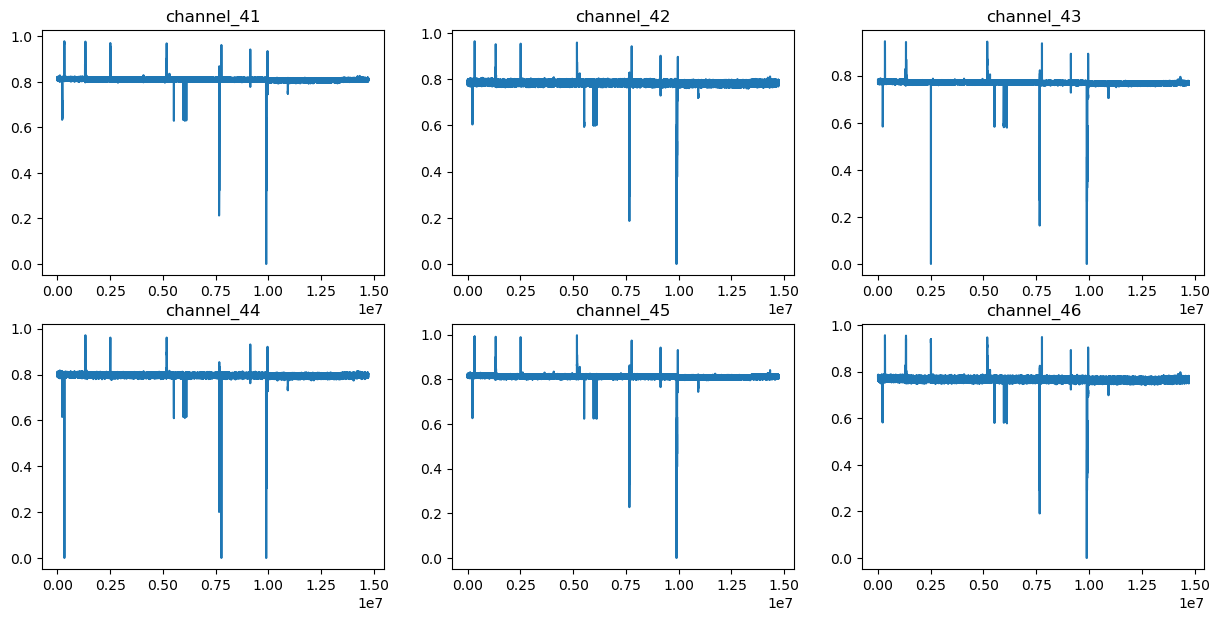

In [22]:
figure, axis = plt.subplots(2, 3)

X = df_sample['id']
Y1 = df_sample['channel_41']
Y2 = df_sample['channel_42']
Y3 = df_sample['channel_43']
Y4 = df_sample['channel_44']
Y5 = df_sample['channel_45']
Y6 = df_sample['channel_46']

figure.set_figheight(7)
figure.set_figwidth(15)

axis[0, 0].plot(X, Y1)
axis[0, 0].set_title("channel_41")

axis[0, 1].plot(X, Y2)
axis[0, 1].set_title("channel_42")

axis[0, 2].plot(X, Y3)
axis[0, 2].set_title("channel_43")

axis[1, 0].plot(X, Y4)
axis[1, 0].set_title("channel_44")

axis[1, 1].plot(X, Y5)
axis[1, 1].set_title("channel_45")

axis[1, 2].plot(X, Y6)
axis[1, 2].set_title("channel_46")

plt.show()

From the charts above, the data in the channels look very similar. Also, it's not clear whether the data points that shoot up are outliers or not (since the dataset has already been processed and treated by ESA)

Plotting original dataset while focusing on a specific location to observe the behavior of data and anomalies.
Plotting the is_anomaly variable at the same time, to look for potential relationships with the data.

### 2.2. Plot section of original dataset and anomalies in parallel

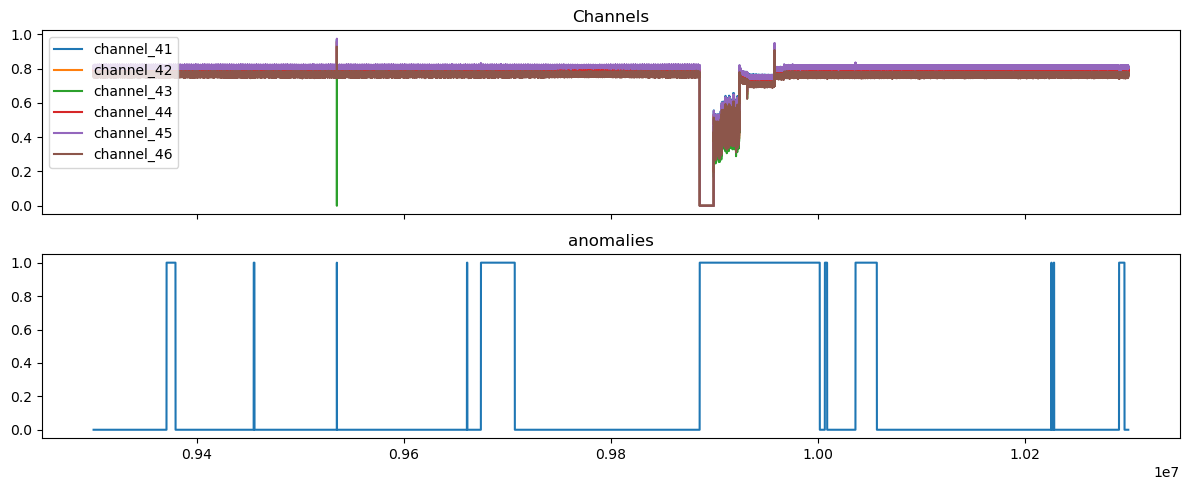

In [46]:
# From the charts above, the data in the channels look very similar. Also, it's not clear whether the data points that
# shoot up are outliers or not (since the dataset has already been processed and treated by ESA)

# Plotting original dataset while focusing on a specific location to observe the behavior of data and anomalies
# Plotting the is_anomaly variable at the same time, to look for potential relationships with the data

xmin = int(9.3*10**6)
xmax = int(10.3*10**6)
df_analysis = df_train_4146[xmin: xmax]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

Just by looking at the data, it seems that there is a big correlation between big changes in the channel values and anomalies happening. However, it also seems that many anomalies happen without a clear change in the channel values.

By observing this behavior, it's possible to infer that the big values in the channels are not outliers, but possible explanation for the occurrence of anomalies.

Below, a similar chart as the previous one is plotted, but using the sample dataset. The objective is to check if no important information was lost during sampling, as some anomalies are very pontual. It's checked if taking a sample still keeps the properties of the original dataset.

### 2.3. Plot section of sample dataset and anomalies in parallel

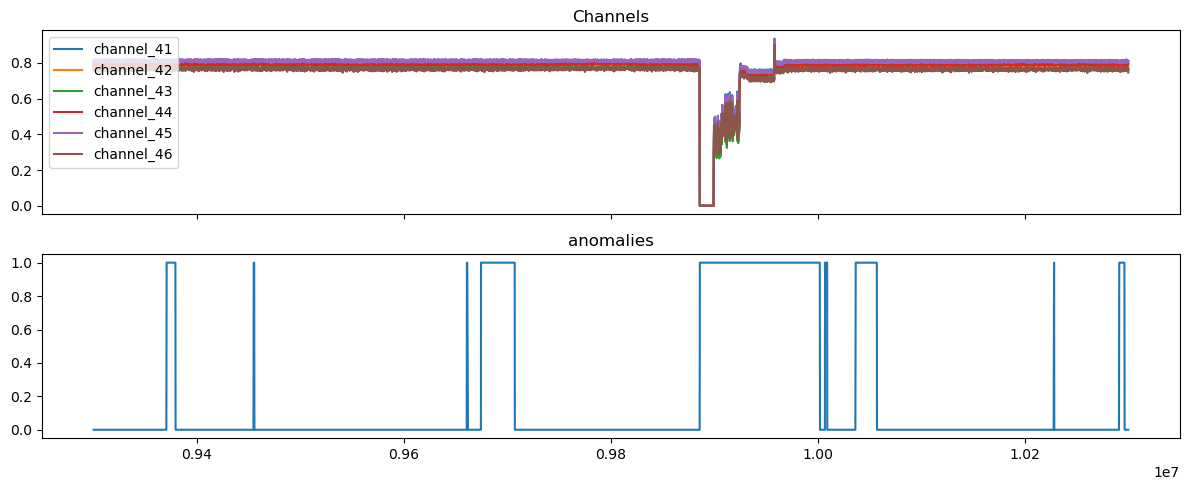

In [47]:
# Using same technique as before but with the sample dataset
# Plotting dataset while focusing on a specific location to observe the behavior of data and anomalies
# Checking if taking a sample still keeps the properties of the original dataset

xmin = int(9.3*10**6)
xmax = int(10.3*10**6)
df_analysis = df_sample[(df_sample['id'] >= xmin) & (df_sample['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

It looks like the properties of the dataset were kept in the sample, so we can use it to do the initial analysis and code more efficiently. Later, the original dataset will be used to train the model and get the definitive solution.

Now, we plot a section of the original dataset where at first, it looks like there are no clear changes in the channel data while an anomaly happens, to try to find if there are any minor changes not easy to see.

### 2.3. Plot section of original dataset and anomalies, looking closely at the behavior of the data

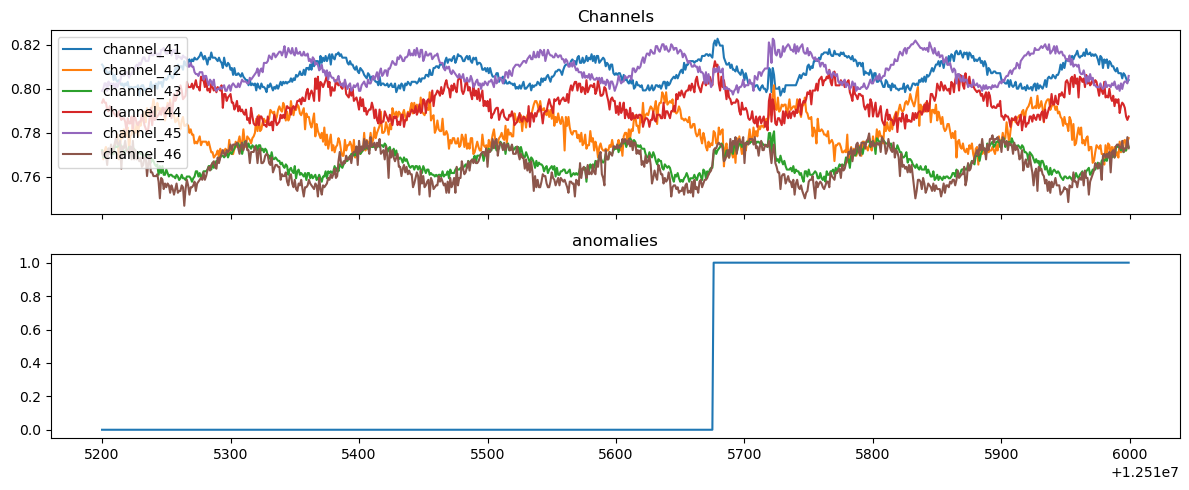

In [ ]:
xmin = int(1.25152*10**7)
xmax = int(1.2516*10**7)

df_analysis = df_train_4146[xmin: xmax]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

In this specific case, it's noticeable that a change, although small, occurs in the channel variables in a time period close to the anomaly

A similar plot will be tried in a different part of the dataset to observe, this time using the sample dataset to check for the maintenance of data properties

### 2.4. Plot section of sample dataset and anomalies, looking closely at the behavior of the data

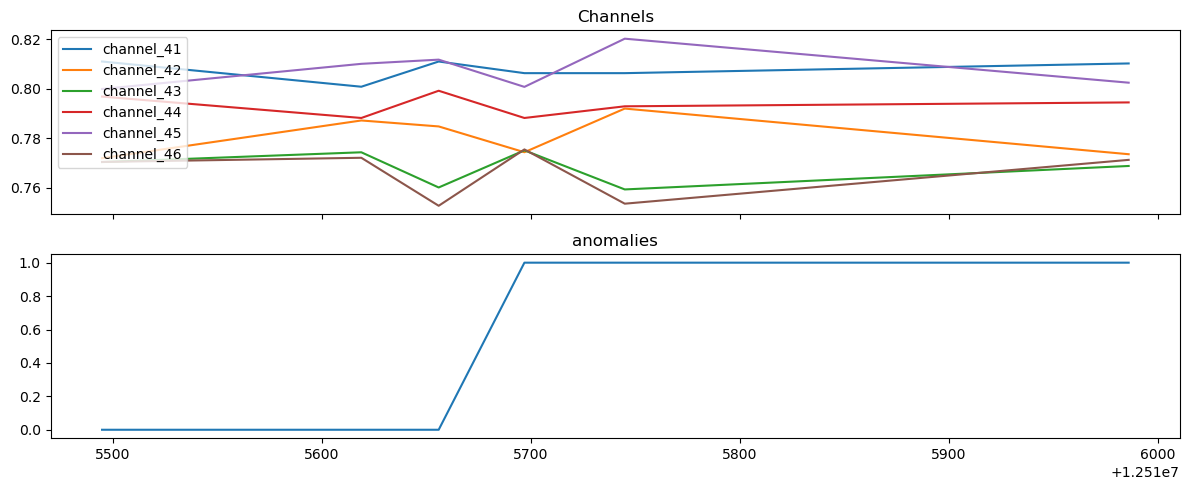

In [45]:
xmin = int(1.25152*10**7)
xmax = int(1.2516*10**7)
df_analysis = df_sample[(df_sample['id'] >= xmin) & (df_sample['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

Here, it's evident that sampling the dataset has removed important features that may explain the behavior of the anomalies. A more adequate approach may be to smoothen the data, which may make it easier to analyze its behavior when anomalies happen.

## 3. Smoothen data and visualize again

At first, the moving average/rolling mean method will be used.

In [ ]:
# Applying moving average/rolling mean to the original dataset

df_train_smooth = df_train_4146.copy()
df_train_smooth['smoothed'] = df_train_4146['y'].rolling(window=5, center=True).mean()

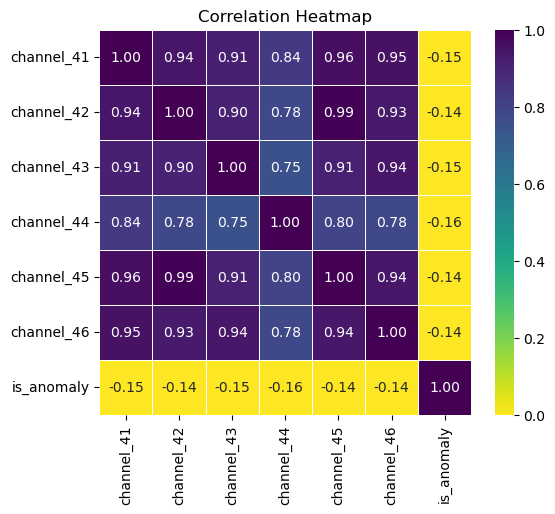

In [12]:
corr_matrix = df_sample.iloc[:, 1:].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="viridis_r", vmin = 0, vmax = 1, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
# Checking skewness of the sample to verify if a log transformation may be applicable
print([skew(i) for i in [Y1, Y2, Y3, Y4, Y5, Y6]])

# All columns are strongly skewed

[-19.987081260812065, -18.801682256835658, -18.834753888827198, -18.605480426360838, -19.573841307386537, -18.489046777296625]


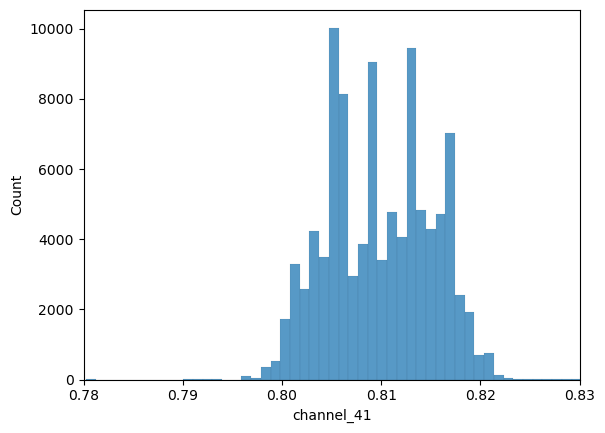

In [14]:
fig, ax = plt.subplots()
sns.histplot(Y1, bins=1000, ax = ax)
ax.set_xlim(0.78, 0.83)
plt.show()

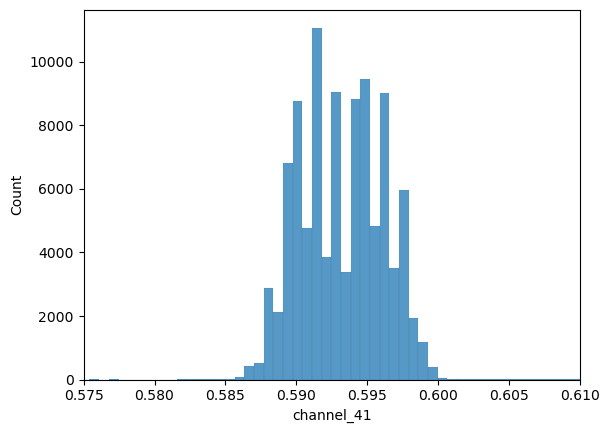

In [15]:
[Y1log, Y2log, Y3log, Y4log, Y5log, Y6log]  = [np.log(i+1) for i in [Y1, Y2, Y3, Y4, Y5, Y6]]

Y1log.replace([np.inf, -np.inf], np.nan, inplace=True)
Y1log.dropna(inplace=True)

fig, ax = plt.subplots()
sns.histplot(Y1log, bins=1000, ax = ax)
ax.set_xlim(0.575, 0.610)
plt.show()

In [16]:
skew(Y1log)

-22.32449048825499

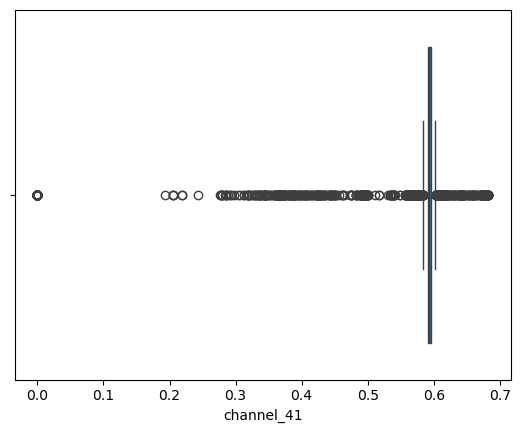

In [17]:
sns.boxplot(x=Y1log)
plt.show()

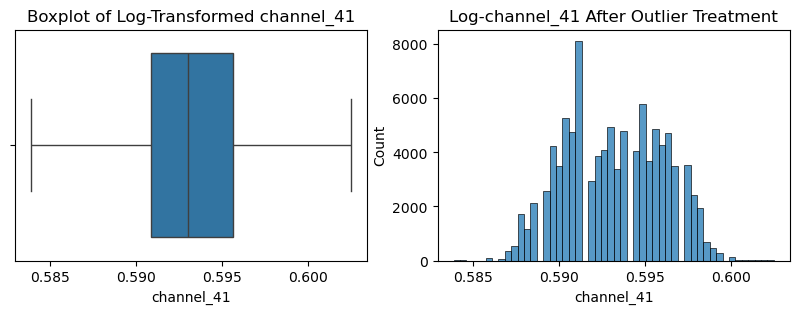

In [18]:
# Outlier removal - After Log Tranform 

Q1 = Y1log.quantile(0.25)
Q3 = Y1log.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = Y1log[(Y1log < lower_bound) | (Y1log > upper_bound)]

Y1log_clean = Y1log[(Y1log >= lower_bound) & (Y1log <= upper_bound)]

fig, ax = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)


sns.boxplot(x=Y1log_clean, ax=ax[0])
ax[0].set_title("Boxplot of Log-Transformed channel_41")

sns.histplot(Y1log_clean, bins=50, ax=ax[1])
ax[1].set_title("Log-channel_41 After Outlier Treatment")

plt.show()

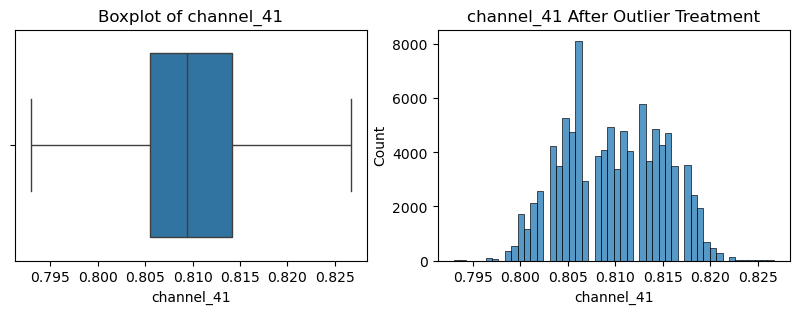

In [19]:
# Outlier removal - No Log Tranform 

Q1 = Y1.quantile(0.25)
Q3 = Y1.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = Y1[(Y1 < lower_bound) | (Y1 > upper_bound)]

Y1_clean = Y1[(Y1 >= lower_bound) & (Y1 <= upper_bound)]

fig, ax = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)


sns.boxplot(x=Y1_clean, ax=ax[0])
ax[0].set_title("Boxplot of channel_41")

sns.histplot(Y1_clean, bins=50, ax=ax[1])
ax[1].set_title("channel_41 After Outlier Treatment")

plt.show()

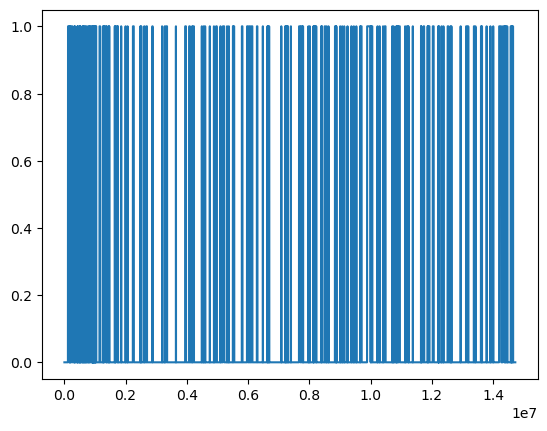

In [20]:
# Plot anomalies to visualize the data

X = np.array(df_train_4146['id'])
y = np.array(df_train_4146['is_anomaly'])

plt.plot(X, y)

In [21]:
X = np.array(sample_df_train['id'])
y = np.array(sample_df_train['is_anomaly'])

plt.plot(X, y)

NameError: name 'sample_df_train' is not defined

In [ ]:
reducer = umap.UMAP()

In [ ]:
df_train_data = sample_df_train[
    [
        "channel_41",
        "channel_42",
        "channel_43",
        "channel_44",
        "channel_45",
        "channel_46"
    ]
].values

scaled_df_train_data = StandardScaler().fit_transform(df_train_data)

In [ ]:
scaled_df_train_data.shape

(50000, 6)

In [ ]:
embedding = umap.UMAP().fit_transform(scaled_df_train_data)
embedding.shape

c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


(50000, 2)

Text(0.5, 1.0, 'UMAP projection of the anomaly dataset')

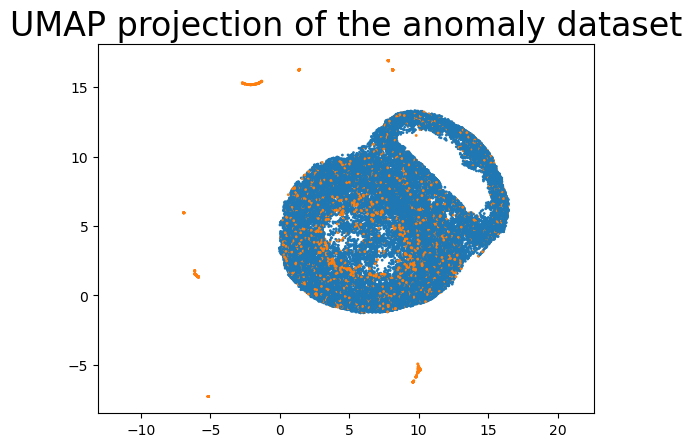

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in sample_df_train["is_anomaly"].map({0:0, 1:1})],
    s=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the anomaly dataset', fontsize=24)

In [ ]:
df_train_4146['is_anomaly'].value_counts().get(0, 0)

13184217